In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from models import LinearAutoEncoder, ConvAutoEncoder, BaselineClassifier, LinearClassifier
from sklearn.metrics import f1_score

### Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Question 2b

In [4]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [5]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1     0.19375    0.14952  
Epoch 2     0.14126    0.13501  
Epoch 3     0.13209    0.12848  
Epoch 4     0.12703    0.12698  
Epoch 5     0.12442    0.12507  
Epoch 6     0.12272    0.12240  
Epoch 7     0.12159    0.12083  
Epoch 8     0.12084    0.12070  
Epoch 9     0.12022    0.11918  
Epoch 10    0.11974    0.12023  


In [6]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 10)

             Train       Dev    
Epoch 1    

 0.18012    0.13463  
Epoch 2     0.12908    0.12424  
Epoch 3     0.12277    0.12112  
Epoch 4     0.11974    0.11969  
Epoch 5     0.11783    0.11682  
Epoch 6     0.11643    0.11518  
Epoch 7     0.11529    0.11453  
Epoch 8     0.11441    0.11345  
Epoch 9     0.11369    0.11272  
Epoch 10    0.11325    0.11329  


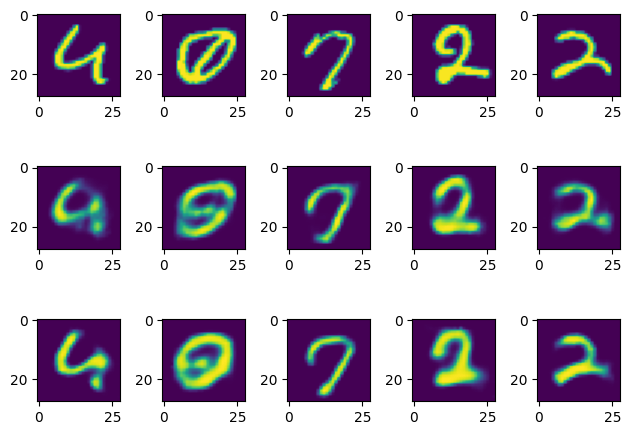

In [7]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

### Question 2c

In [12]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [15]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder_linear.forward(x).detach()
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder_linear.forward(x).detach()
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')

In [14]:
classifier_base = BaselineClassifier().cuda()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 10)

             Train       Test   
Epoch 1     2.34999    2.34765  
Epoch 2     2.34925    2.34765  
Epoch 3     2.34925    2.34765  
Epoch 4     2.34925    2.34765  
Epoch 5     2.34925    2.34765  
Epoch 6     2.34925    2.34765  
Epoch 7     2.34925    2.34765  
Epoch 8     2.34925    2.34765  
Epoch 9     2.34925    2.34765  
Epoch 10    2.34925    2.34765  


In [16]:
classifier_linear = LinearClassifier().cuda()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001), 10)

             Train       Test   
Epoch 1     0.46760    0.26822  
Epoch 2     0.25001    0.22869  
Epoch 3     0.21641    0.21962  
Epoch 4     0.19610    0.19547  
Epoch 5     0.18220    0.19892  
Epoch 6     0.17163    0.18953  
Epoch 7     0.16044    0.18096  
Epoch 8     0.15322    0.17071  
Epoch 9     0.14615    0.17250  
Epoch 10    0.14104    0.17463  
